# Load packages

In [1]:
#import CNN environment
import torch, torchvision
from torch.utils.cpp_extension import CUDA_HOME; 

# import common libraries
import numpy as np
import cv2
import os
import random
import matplotlib.pylab as plt
from PIL import Image
from tqdm import tqdm
import timeit

# import some detectron2 utilities
import detectron2

from Nucleus import ImageInput
from Nucleus import ImageTile
from Nucleus import Stitcher
from detectron2_predict import detectron_predict

from utils import PNG_to_JSON
from Nucleus import coco_nucleus
from skimage import io

Nucleus


# Change parameters in the following box and run the rest

Save images in the folder ./test/img

Save the model in the folder ./model

Output:

    masks in ./test/masks
    overlay and json file in ./output

In [12]:
#Name of the image to analyse (one at a time for now)
#Images should be divisible by 256 or 128 e.g. 1024x1024 or 2084x512
input_img = "img_z164.tif"

#Stitching mode (stitch_v1 or stitch_v2):
stitch_version = "stitch_v2"

#Optional parameters to change
step_input= 256
margin_input = 5
#Parameters for Stitching_v2
overlap_input = 74
offset_input = 0.8

# Core code (do not modify)

Just kidding you can modify it if you wish :)

Input image shape: (1024, 1024, 3)
Minimum pixel value: 0
Maximum pixel value: 255
Using step of 256px.
Using step of 74px.


  2%|▏         | 7/414 [00:00<00:06, 60.79it/s]

Tiling, prediction and stitching done


100%|██████████| 414/414 [00:07<00:00, 53.67it/s]


Done!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
COCO categories: 
nucleus



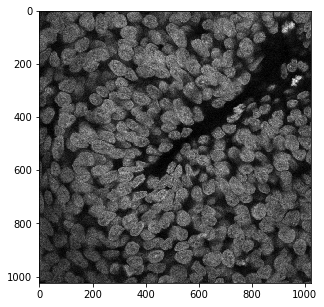

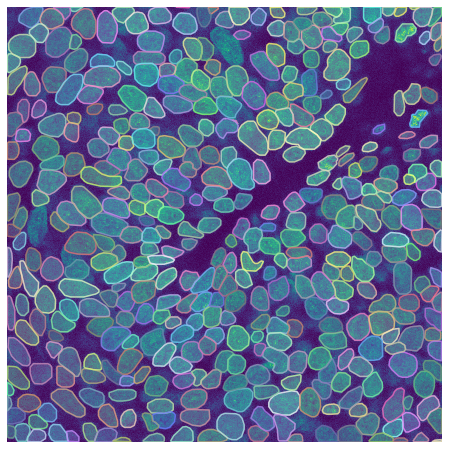

In [13]:
#Set up paths
ROOT_PATH = "./test/"
IMG_PATH = "img/"
MASKS_PATH = "masks/"

#Load and show image
one = ImageInput(ROOT_PATH+IMG_PATH+input_img, step=step_input, overlap = overlap_input)
one.show_me()

#Generate tiles, predict and stitch according to the specified version
if stitch_version == 'stitch_v1':
    m_tiles, v_tiles, h_tiles = one.make_tiles('stitch_v1')
    m_out = [detectron_predict(_im) for _im in m_tiles]
    v_out = [detectron_predict(_im) for _im in v_tiles]
    h_out = [detectron_predict(_im) for _im in h_tiles]
    test = Stitcher(one)
    seg_mask, nuclei_tally = test.stitch_v1([m_tiles,v_tiles,h_tiles] , [m_out, v_out, h_out], margin=margin_input)
    print("Tiling, prediction and stitching done")
    
elif stitch_version == 'stitch_v2':
    tiles = one.make_tiles('stitch_v2')
    out = [detectron_predict(_im) for _im in tiles]
    test = Stitcher(one)
    seg_mask, nuclei_tally = test.stitch_v2(tiles , out, margin=margin_input, offset=offset_input)
    print("Tiling, prediction and stitching done")

else:
    print("Please use a valid stitching format")


#Save a mask, a json file and a overlay between the original image and the segmented nuclei
#Generate mask
im = Image.fromarray(seg_mask)
im.save(ROOT_PATH+MASKS_PATH+input_img)

#Generate Json file
PNG_to_JSON.coco_output(ROOT_DIR=ROOT_PATH,
                        image_files=[input_img],
                        output='./output/'+ input_img.split('.')[0]+'_'+stitch_version +'_'+ '.json') 


#Generate overlay image
segmFile = './output/'+ input_img.split('.')[0]+'_'+stitch_version +'_'+ '.json'
imgDir   = ROOT_PATH+IMG_PATH
output_imageFile = './output/'+ input_img.split('.')[0]+'_'+stitch_version +'_'+ '.png'
pick_image_number=0


coco=coco_nucleus(segmFile)
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))
catIds = coco.getCatIds(catNms=['nucleus']);
imgIds = coco.getImgIds(catIds=catIds);
img = coco.loadImgs(imgIds[pick_image_number])[0]


plt.figure(figsize=(8,8))
I = io.imread(imgDir+img['file_name'])
plt.imshow(I); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds)
anns = coco.loadAnns(annIds)
coco.showAnns_Nucleus(anns)
plt.savefig(output_imageFile,dpi=300,bbox_inches='tight',pad_inches=0)   

# Specific functions to extract information

In [ ]:
#To be determined
#Suggestions accepted